# FastCampus Data Science School 6
# Classification Team Project

- Team : Team 1, Outliers (조한준, 강민구, 신신호)<br>
- Topic : Shelter Animal Outcomes(Kaggle)<br>
- Using a dataset of intake information including breed, color, sex, and age from the <font color="red">Austin Animal Center</font><br>
- Submissions are evaluated using the multi-class logarithmic loss. Each incident has been labeled with one true class. For each animal, you must submit a set of predicted probabilities (one for every class).
<br><br>
- ref) https://github.com/JihongL/Shelter-Animal-Outcomes.git

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import *
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

import warnings

from sklearn.model_selection import GridSearchCV


warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 30000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 데이터 탐색
- df : 원본 train 데이터를 담은 Dataframe

In [2]:
df = pd.read_csv('data/train.csv')
print(np.shape(df))
df.tail(3)

(26729, 10)


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [3]:
print('AnimalID', len(df['AnimalID'].unique()))
print('Name', len(df['Name'].unique()))
print('DateTime', len(df['DateTime'].unique()))
print('OutcomeType', len(df['OutcomeType'].unique()))
print('OutcomeSubtype', len(df['OutcomeSubtype'].unique()))
print('AnimalType', len(df['AnimalType'].unique()))
print('SexuponOutcome', len(df['SexuponOutcome'].unique()))
print('AgeuponOutcome', len(df['AgeuponOutcome'].unique()))
print('Breed', len(df['Breed'].unique()))
print('Color', len(df['Color'].unique()))

AnimalID 26729
Name 6375
DateTime 22918
OutcomeType 5
OutcomeSubtype 17
AnimalType 2
SexuponOutcome 6
AgeuponOutcome 45
Breed 1380
Color 366


### [데이터 탐색 결과]<br>
1) AnimalID : 동물의 일련번호로 primary key 역할을 한다 <font color="blue">(정수로 encoding 필요)</font><br><br>
2) Name : 동물의 이름. <font color="blue">(가장 많은 'Max'도 136마리에 불과하므로 binarize만 한다)</font><br><br>
3) DateTime : 결과가 행해진 시간. <font color="blue">(계절성을 띄는지 등의 변수 특성을 탐색할 필요가 있음)</font><br><br>
4) OutcomeType : 결과의 형태이자 <font color="red">Target</font>. 결과는 Adoption, Transfer, Return, Euthanasia(안락사), Died로 다섯 가지.<font color="blue">(Labeling필요)</font><br><br>
5) AnimalType : 동물의 종. dog와 cat 두가지로 나뉜다.<font color="blue">(dog면 1, cat이면 0으로 binarize필요)</font><br><br>
6) SexuponOutcome : 중성화 여부. 남성/여성/중성화남성/중성화여성/unknown으로 크게 다섯 가지로 나뉜다.<font color="blue">(성의 중요도도 클 것이라 예상)</font><br><br>
7) AgeuponOutcome : 결과가 행해질 당시의 동물의 나이.<font color="blue">(매우 중요할 것으로 예상, 단위 통일 필요)</font><br><br>
8) Breed : 동물의 종<font color="blue">(개/고양이의 세부 종, <font color="red">1380종</font>으로 매우 다양)</font><br><br>
9) Color : 동물의 색 <font color="blue">(<font color="red">366가지</font>로 매우다양)</font><br>

# 데이터 전처리
- 전처리 된 독립변수를 df_pre에 새로 저장한다

In [4]:
df_pre = df.copy()

## OutcomeType
- Label Binarizer를 통해 문자열을 labeling 처리

In [5]:
df_pre['OutcomeType'].value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [6]:
encoder = LabelEncoder()
df_pre['OutcomeType'] = encoder.fit_transform(df_pre['OutcomeType'])

In [7]:
df_pre['OutcomeType'].value_counts()

0    10769
4     9422
3     4786
2     1555
1      197
Name: OutcomeType, dtype: int64

## Name
- Label Binarizer를 통해 문자열을 labeling 처리

In [8]:
def Naming(x):
    if type(x) == float:
        return 0
    else:
        return 1

In [9]:
df_pre['Name'] = df['Name'].transform(Naming)

In [10]:
df_pre['Name'].value_counts()

1    19038
0     7691
Name: Name, dtype: int64

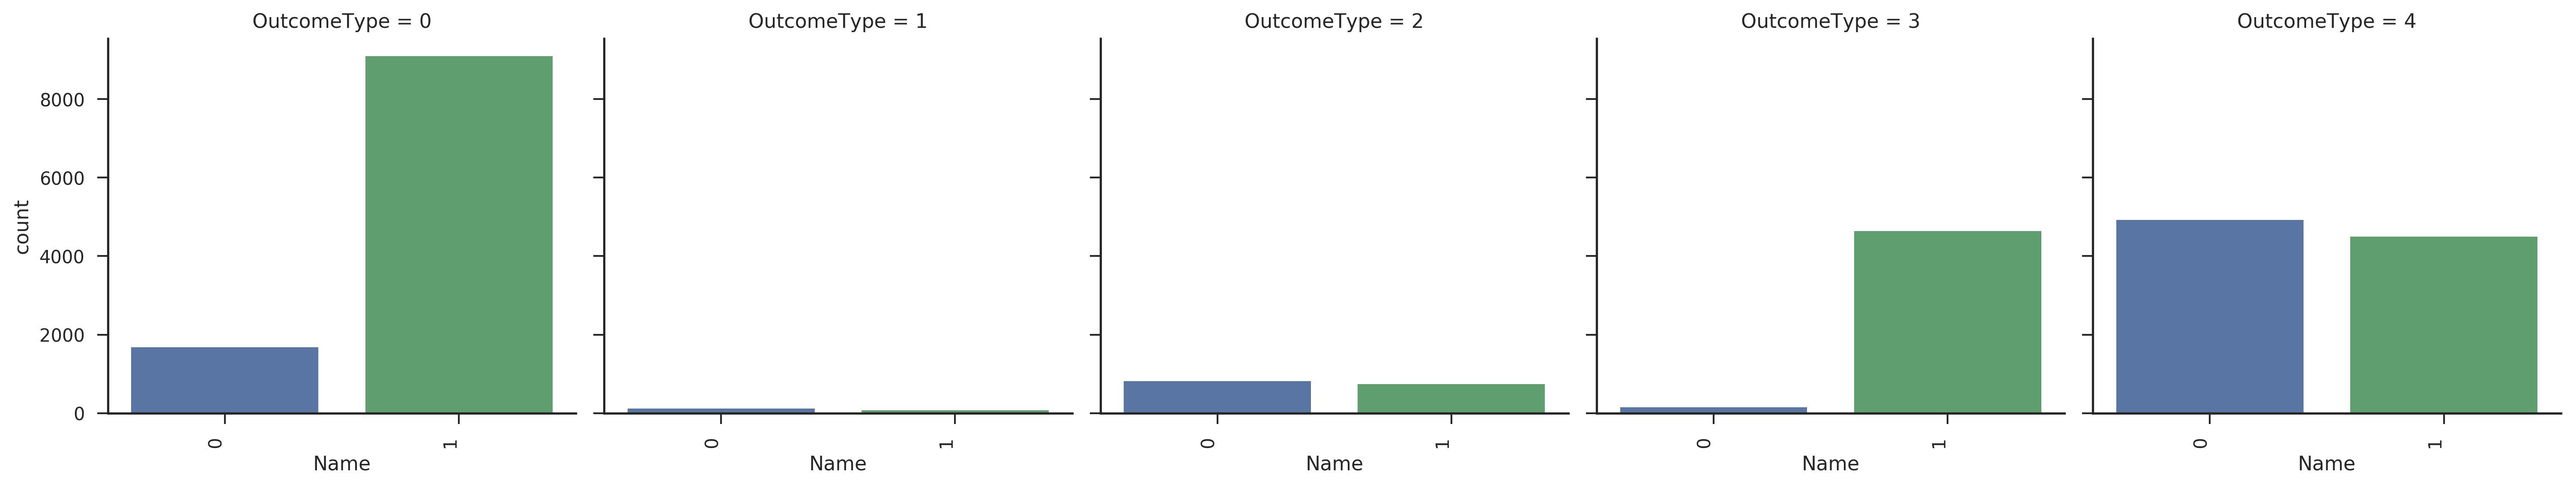

In [11]:
import seaborn as sns
sns.set(style="ticks")
ax = sns.factorplot(x="Name", col="OutcomeType", data=df_pre, kind='count' )
ax.set_xticklabels(rotation=90, ha="right")

## Color
- Color는 약 366종류로 다양하게 분포되어 있으며, 비슷하거나 mix된 경우도 많다. <br> 따라서 메인 색상(대표하는 색, 믹스된 경우 먼저 나온 색상을 사용)만을 남겨놓고 통합했다.<br><font color="blue">예시) 'Brown Tabby/White' --> 'Brown'</font><br>
- 그 결과 <font color="red">366종의 컬러를 25종으로</font> 줄일 수 있었다.

In [12]:
# 'A/B' = 'A'로 표기
def color_del(x):
    if '/' in x:
        x = x[0:x.index('/')]
        return x
    else:
        return x

In [13]:
df_pre['Color_pre'] = df['Color'].copy()
df_pre['Color_pre'] = df_pre['Color_pre'].apply(color_del)

In [14]:
print(len(df_pre['Color'].unique()))
print(len(df_pre['Color_pre'].unique()))

366
57


In [15]:
# 대표 컬러로 통합
def color_union(x):
    if 'Black' in x:
        x = 'Black'
        return x
    elif 'Blue' in x:
        x = 'Blue'
        return x
    elif 'Red' in x:
        x = 'Red'
        return x
    elif 'Silver' in x:
        x = 'Silver'
        return x
    elif 'Brown' in x:
        x = 'Brown'
        return x
    elif 'Orange' in x:
        x = 'Orange'
        return x
    elif 'Cream' in x:
        x = 'Cream'
        return x
    elif 'Gray' in x:
        x = 'Gray'
        return x
    elif 'Calico' in x:
        x = 'Calico'
        return x
    elif 'Chocolate' in x:
        x = 'Chocolate'
        return x
    elif 'Tortie' in x:
        x = 'Tortie'
        return x
    elif 'Yellow' in x:
        x = 'Yellow'
        return x
    elif 'Liver' in x:
        x = 'Liver'
        return x
    else:
        return x

In [16]:
df_pre['Color_pre'] = df_pre['Color_pre'].apply(color_union)

In [17]:
# 40마리 이하인 색깔은 'etc'로 통합
df_pre['Color_pre'] = df_pre['Color_pre'].replace('Agouti', 'etc')
df_pre['Color_pre'] = df_pre['Color_pre'].replace('Apricot', 'etc')
df_pre['Color_pre'] = df_pre['Color_pre'].replace('Lilac Point', 'etc')
df_pre['Color_pre'] = df_pre['Color_pre'].replace('Pink', 'etc')
df_pre['Color_pre'] = df_pre['Color_pre'].replace('Ruddy', 'etc')

In [18]:
print(len(df_pre['Color'].unique()))
print(len(df_pre['Color_pre'].unique()))

366
25


## AgeuponOutcome (단위 통일)
- 중구난방인 단위의 나이 데이터들을 모두 한 단위, day로 통일시켜 주었다.

In [19]:
def DayuponOutcome(age_str):
    num, unit = age_str.split(' ')
    if unit == 'day' or unit == 'days':
        return( int(num) )
    elif unit == 'week' or unit == 'weeks':
        return(int(num) * 7 )
    elif unit == 'month' or unit == 'months':
        return(int(num) * 30 )
    elif unit == 'year' or unit == 'years':
        return(int(num) * 365 )

In [20]:
df_pre['DayuponOutcome'] = df_pre['AgeuponOutcome'].copy()
df_pre['DayuponOutcome'] = df_pre['DayuponOutcome'].fillna('0 day')
df_pre['DayuponOutcome'] = df_pre['DayuponOutcome'].apply(DayuponOutcome)

In [21]:
df_pre['AgeuponOutcome'].fillna('Unknown', inplace=True)

- 나이로도 추가해봄

In [22]:
def Age(x):
    if 0 < x < 730:
        return 2
    elif 731 < x < 1460:
        return 4
    elif 1461 < x < 2190:
        return 6
    elif 2191 < x < 2920:
        return 8
    elif 2921 < x < 3650:
        return 10
    elif 3651 < x < 4380:
        return 12
    elif 4381 < x < 5110:
        return 14
    elif 5111 < x < 5840:
        return 16
    elif 5841 < x < 6570:
        return 18
    else:
        return 20    

In [23]:
df_pre['AboutAge'] = df_pre['DayuponOutcome'].copy()
df_pre['AboutAge'] = df_pre['AboutAge'].apply(Age)

In [24]:
df_pre.tail(3)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Color_pre,DayuponOutcome,AboutAge
26726,A698128,1,2015-03-09 13:33:00,0,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,White,1460,20
26727,A677478,0,2014-04-27 12:22:00,4,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,Black,28,2
26728,A706629,0,2015-07-02 09:00:00,4,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,Brown,365,2


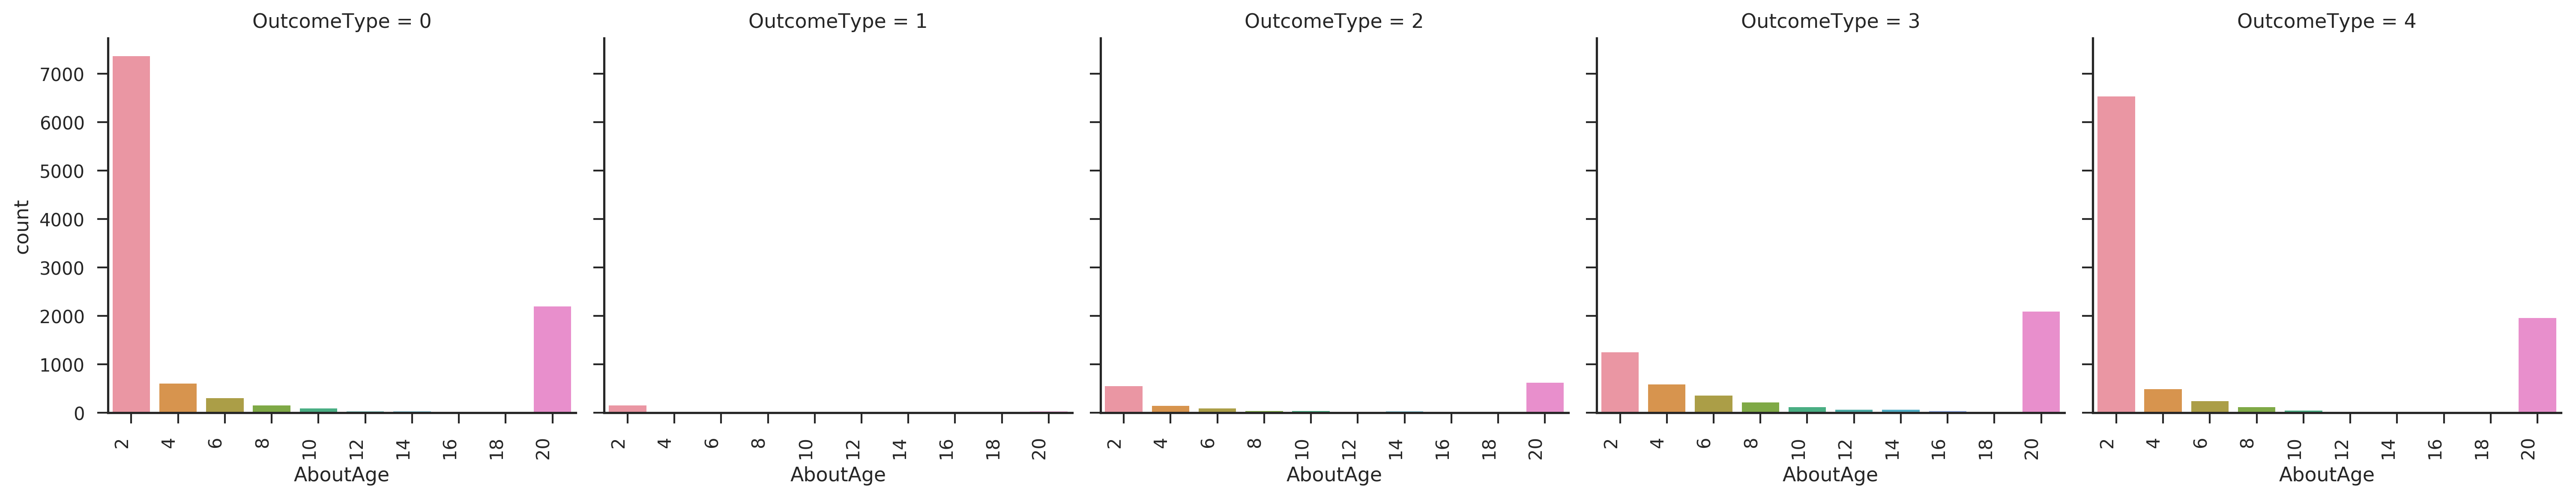

In [25]:
sns.set(style="ticks")
ax = sns.factorplot(x="AboutAge", col="OutcomeType", data=df_pre, kind='count' )
ax.set_xticklabels(rotation=90, ha="right")

## Breed (전처리)
- Mix는 별도의 컬럼으로 만들어 binarize(mix는 1, 순종은 0)

In [26]:
def BreedMix(x):
    if '/' in  x:
        return 1
    elif 'Mix' in x:
        return 1
    else:
        return 0

In [27]:
df_pre['BreedMix'] = df_pre['Breed'].apply(BreedMix)

In [28]:
def Nature_Breed(x):
    if '/' in x:
        x = x[0:x.index('/')]
        return x
    elif ' Mix' in x:
        x = x[0:-4]
        return x
    else:
        return x

In [29]:
df_pre['Breed_pre'] = df_pre['Breed'].copy()
df_pre['Breed_pre'] = df_pre['Breed_pre'].apply(Nature_Breed)

In [30]:
print(len(df['Breed'].unique()))
print(len(df_pre['Breed_pre'].unique()))

1380
220


## AnimalType (Binarize)
- dog는 1, cat은 0

In [31]:
encoder = LabelEncoder()
df_pre['AnimalType'] = encoder.fit_transform(df['AnimalType'])

In [32]:
df_pre['AnimalType'].value_counts()

1    15595
0    11134
Name: AnimalType, dtype: int64

## SexuponOutcome
- Nan값을 Unknown으로 처리

In [33]:
df_pre['SexuponOutcome'].fillna("Unknown", inplace=True)

In [34]:
df_pre['SexuponOutcome'].value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1094
Name: SexuponOutcome, dtype: int64

## AnimalID (string제거, 정수화)

In [35]:
df_pre['AnimalID'] = encoder.fit_transform(df['AnimalID'])

In [36]:
df_pre.tail(3)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Color_pre,DayuponOutcome,AboutAge,BreedMix,Breed_pre
26726,16731,1,2015-03-09 13:33:00,0,NaN,1,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,White,1460,20,1,Old English Bulldog
26727,7450,0,2014-04-27 12:22:00,4,Partner,0,Intact Male,4 weeks,Domestic Shorthair Mix,Black,Black,28,2,1,Domestic Shorthair
26728,20751,0,2015-07-02 09:00:00,4,SCRP,0,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,Brown,365,2,1,Domestic Shorthair


## DateTime 전처리 및 분석

In [37]:
import re

In [38]:
def MakeYear(x):
    A = re.search(r'\d\d\d\d', str(x))
    return A.group()

def MakeMonth(x):
    A = re.search(r'-\d\d-', str(x))
    B = re.search(r'\d\d', str(A))
    return B.group()

def Integerize(x):
    x = int(x)
    return x

In [39]:
df_pre['Year'] = df_pre['DateTime'].apply(MakeYear)
df_pre['Month'] = df_pre['DateTime'].apply(MakeMonth)
df_pre['YearMonth'] = df_pre['Year'] + df_pre['Month']
df_pre['Year'] = df_pre['Year'].apply(Integerize)
df_pre['Month'] = df_pre['Month'].apply(Integerize)
df_pre['YearMonth'] = df_pre['YearMonth'].apply(Integerize)

In [40]:
def MakeHour(x):
    A = re.search(r' \d\d:', str(x))
    B = re.search(r'\d\d', A.group())
    return B.group()

df_pre['Hour'] = df['DateTime'].apply(MakeHour)
df_pre['Hour'] = df_pre['Hour'].apply(Integerize)

In [41]:
df_pre.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Color_pre,DayuponOutcome,AboutAge,BreedMix,Breed_pre,Year,Month,YearMonth,Hour
0,5419,1,2014-02-12 18:22:00,3,NaN,1,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Brown,365,2,1,Shetland Sheepdog,2014,2,201402,18
1,1603,1,2013-10-13 12:44:00,2,Suffering,0,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Cream,365,2,1,Domestic Shorthair,2013,10,201310,12
2,11613,1,2015-01-31 12:28:00,0,Foster,1,Neutered Male,2 years,Pit Bull Mix,Blue/White,Blue,730,20,1,Pit Bull,2015,1,201501,12
3,10238,0,2014-07-11 19:09:00,4,Partner,0,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,Blue,21,2,1,Domestic Shorthair,2014,7,201407,19
4,3501,0,2013-11-15 12:52:00,4,Partner,1,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Tan,730,20,1,Lhasa Apso,2013,11,201311,12


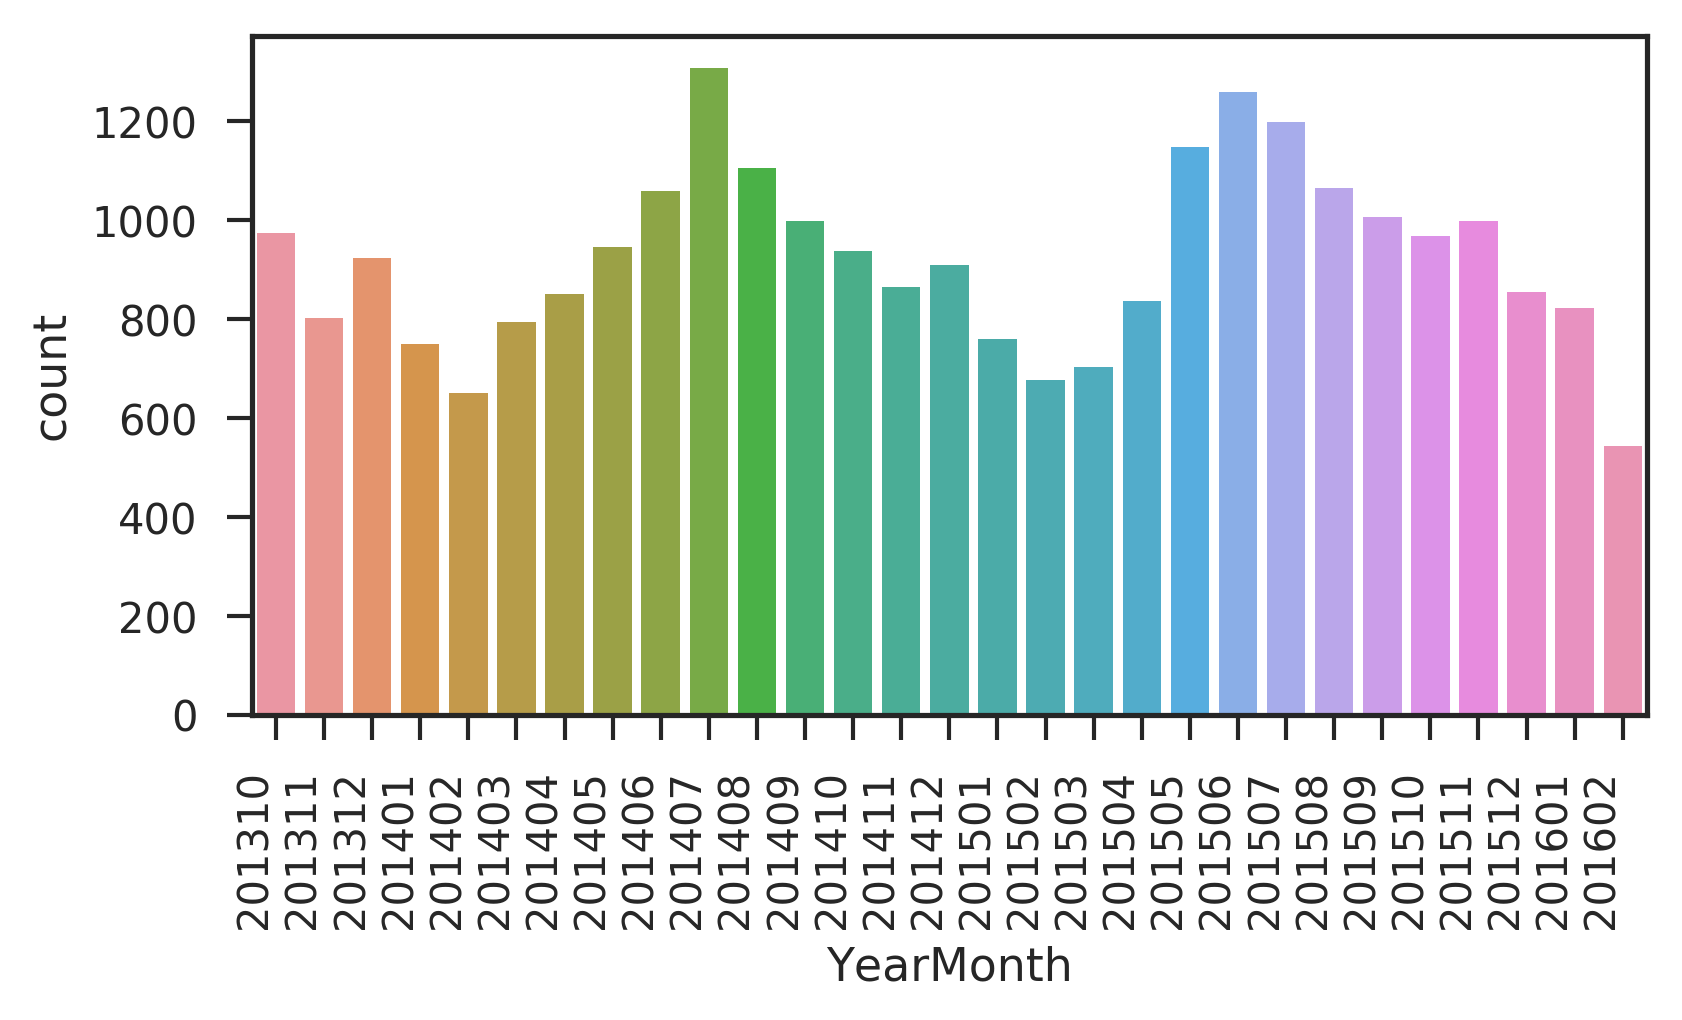

In [42]:
import seaborn as sns
plt.figure(figsize=(6,3))
ax = sns.countplot(x="YearMonth", data=df_pre, order=[201310, 201311, 201312, 201401, 201402, 201403, 201404, 201405, 201406, 201407, 201408, 201409, 201410, 201411, 201412, 201501, 201502, 201503, 201504, 201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512, 201601, 201602])
ax.set_xticklabels(labels=[201310, 201311, 201312, 201401, 201402, 201403, 201404, 201405, 201406, 201407, 201408, 201409, 201410, 201411, 201412, 201501, 201502, 201503, 201504, 201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512, 201601, 201602], rotation=90, ha="right")

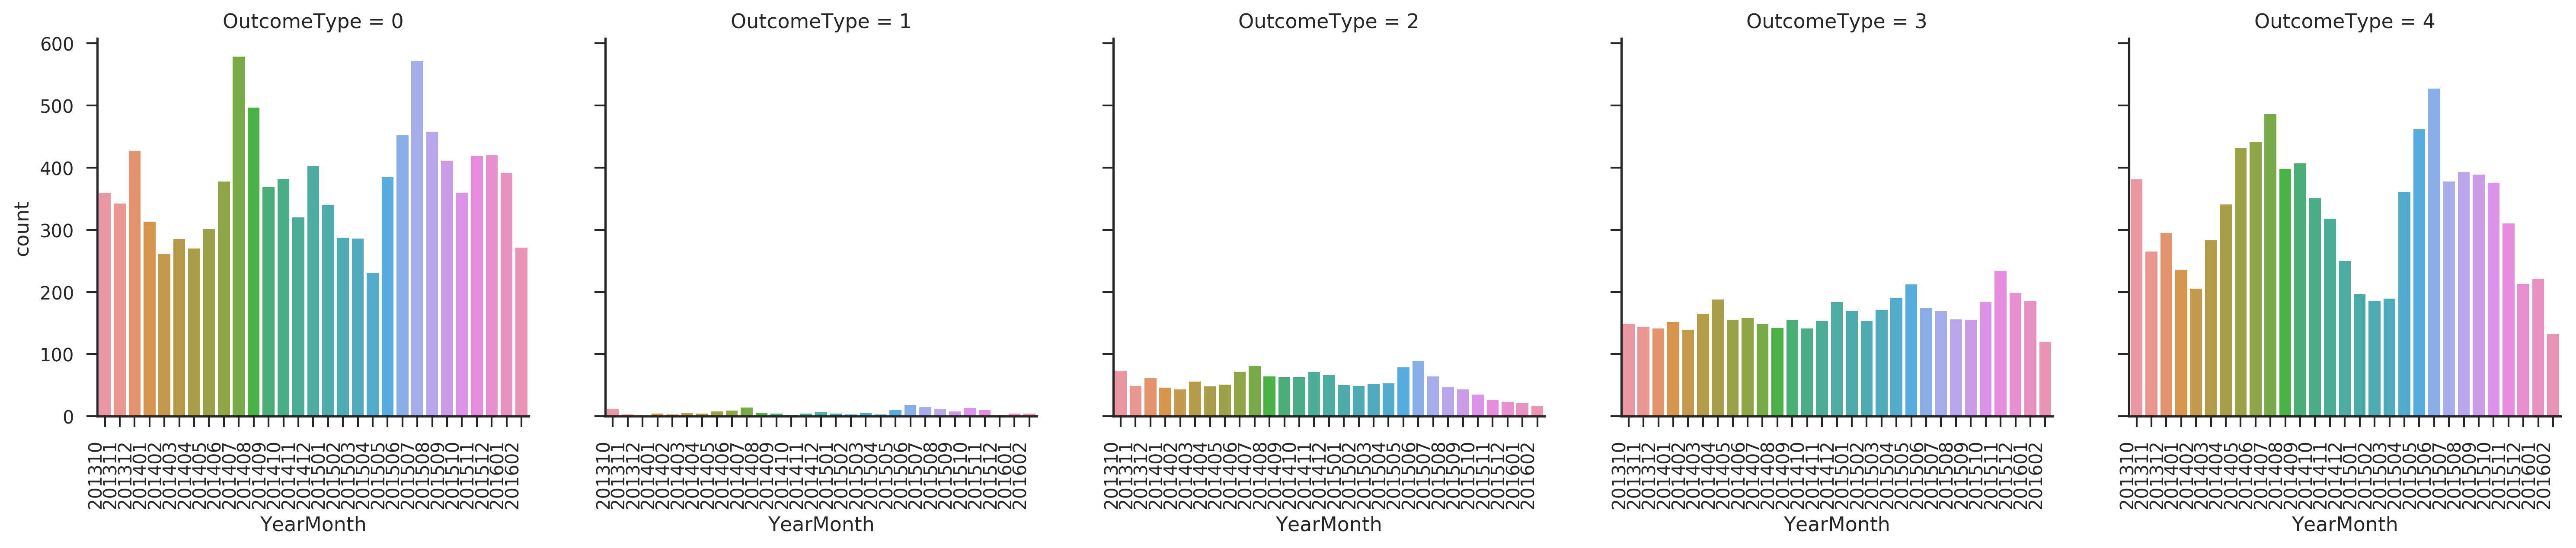

In [43]:
sns.set(style="ticks")
ax = sns.factorplot(x="YearMonth", col="OutcomeType", data=df_pre, kind='count' )
ax.set_xticklabels(rotation=90, ha="right")

In [44]:
df.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


### - DateTime을 계절로 변환하여 추가

In [45]:
df_pre['Season'] = df_pre['Month'].copy()
df_pre['Season'] = df_pre['Season'].apply(Integerize)

In [46]:
def Seasonerize(x):
    if x == 12 or x == 1 or x == 2:
        return 'Winter'
    elif 2 < x < 6:
        return 'Spring'
    elif 5 < x < 9:
        return 'Summer'
    elif 8 < x < 12:
        return 'Automn'
    else:
        return 'Unknown'

In [47]:
df_pre['Season'] = df_pre['Season'].apply(Seasonerize)
df_pre.tail(3)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Color_pre,DayuponOutcome,AboutAge,BreedMix,Breed_pre,Year,Month,YearMonth,Hour,Season
26726,16731,1,2015-03-09 13:33:00,0,NaN,1,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,White,1460,20,1,Old English Bulldog,2015,3,201503,13,Spring
26727,7450,0,2014-04-27 12:22:00,4,Partner,0,Intact Male,4 weeks,Domestic Shorthair Mix,Black,Black,28,2,1,Domestic Shorthair,2014,4,201404,12,Spring
26728,20751,0,2015-07-02 09:00:00,4,SCRP,0,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,Brown,365,2,1,Domestic Shorthair,2015,7,201507,9,Summer


In [48]:
df_pre['Season'].value_counts()

Automn    7553
Summer    6997
Winter    6898
Spring    5281
Name: Season, dtype: int64

### - DateTime을 분기로 변환하여 추가

In [49]:
df_pre['Quarter'] = df_pre['Month'].copy()
df_pre['Quarter'] = df_pre['Quarter'].apply(Integerize)

In [50]:
def Quarterize(x):
    if 0 < x < 4:
        return '1/4'
    elif 3 < x < 7:
        return '2/4'
    elif 6 < x < 10:
        return '3/4'
    elif 9 < x < 13:
        return '4/4'
    else:
        return 'Unknown'    

In [51]:
df_pre['Quarter'] = df_pre['Quarter'].apply(Quarterize)
df_pre.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Color_pre,DayuponOutcome,AboutAge,BreedMix,Breed_pre,Year,Month,YearMonth,Hour,Season,Quarter
26724,18631,0,2015-05-14 11:56:00,4,Partner,0,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,Brown,30,2,1,Domestic Shorthair,2015,5,201505,11,Spring,2/4
26725,26055,0,2016-01-20 18:59:00,4,SCRP,0,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,Brown,90,2,1,Domestic Shorthair,2016,1,201601,18,Winter,1/4
26726,16731,1,2015-03-09 13:33:00,0,NaN,1,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,White,1460,20,1,Old English Bulldog,2015,3,201503,13,Spring,1/4
26727,7450,0,2014-04-27 12:22:00,4,Partner,0,Intact Male,4 weeks,Domestic Shorthair Mix,Black,Black,28,2,1,Domestic Shorthair,2014,4,201404,12,Spring,2/4
26728,20751,0,2015-07-02 09:00:00,4,SCRP,0,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,Brown,365,2,1,Domestic Shorthair,2015,7,201507,9,Summer,3/4


In [52]:
df_pre['Quarter'].value_counts()

4/4    8240
3/4    6682
2/4    6102
1/4    5705
Name: Quarter, dtype: int64

## 성향 그룹 추가
- 동물의 성향이 Adoption에 영향을 미칠 것이다.
- 강아지의 성향 기준은 American Kennel Club(AKC), United Kennel Club (UKC)의 기준을 크롤링해서 dataframe화 했다.

In [53]:
from bs4 import BeautifulSoup
import requests
import pandas as pd


info_url = 'http://www.akc.org/public-education/resources/dog-breeds-sorted-groups/'
response = requests.get(info_url)
soup = BeautifulSoup(response.content.decode('latin1'), 'lxml')
breed_group = list()
group_element = list()

groups = soup.select('h2')
for group in groups:
    breed_group.append(group.get_text())


group_element = breed_group
group_element

['HERDING GROUP',
 'HOUND GROUP',
 'TOY GROUP',
 'NON-SPORTING GROUP',
 'SPORTING GROUP',
 'TERRIER GROUP',
 'WORKING GROUP',
 'MISCELLANEOUS CLASS']

In [54]:
group_lists = soup.select('ol')

dog_list = list()
for num,group_list in enumerate(group_lists):
    group_lst = group_list.select('li')
    breed_group[num] = list()
    for dog_breeds in group_lst:
        dog_breed = dog_breeds.find('a')
        breed_group[num].append(dog_breed.get_text())

- Manchester Terrier가 중복기입 되어있어서 Toy Group에서 제외.

In [55]:
breed_group[2].remove("Manchester Terrier")

- 기준에는 없지만 동물 수가 많아서 분류가 필요한 종들은 구글링을 통해서 추가로 분류해줬다.

In [56]:
breed_group[0].append('Catahoula')
breed_group[0].append('German Shepherd')
breed_group[2].append('Chihuahua Shorthair')
breed_group[3].append('Miniature Poodle')
breed_group[5].append('Jack Russell Terrier')
breed_group[5].append('Pit Bull')

In [57]:
df_herding = pd.DataFrame(breed_group[0], columns=['Breed_pre'])
df_herding["Group"] = "Herding Group"

df_hound = pd.DataFrame(breed_group[1], columns=['Breed_pre'])
df_hound["Group"] = "Hound Group"

df_toy = pd.DataFrame(breed_group[2], columns=['Breed_pre'])
df_toy["Group"] = "Toy Group"

df_non_sporting = pd.DataFrame(breed_group[3] , columns=['Breed_pre'])
df_non_sporting["Group"] = "Non_Sporting Group"

df_sporting = pd.DataFrame(breed_group[4], columns=['Breed_pre'])
df_sporting["Group"] = "Sporting Group"

df_terrier = pd.DataFrame(breed_group[5], columns=['Breed_pre'])
df_terrier["Group"] = "Terrier Group"

df_working = pd.DataFrame(breed_group[6], columns=['Breed_pre'])
df_working["Group"] = "Working Group"

df_miscellaneous = pd.DataFrame(breed_group[7], columns=['Breed_pre'])
df_miscellaneous["Group"] = "Miscellaneous Class"

df_cat1 = pd.DataFrame({'Breed_pre' : ['Domestic Shorthair'],'Group': ['cat1']})
df_cat2 = pd.DataFrame({'Breed_pre' : ['Domestic Medium Hair'],'Group': ['cat2']})
df_cat3 = pd.DataFrame({'Breed_pre' : ['Domestic Longhair'],'Group': ['cat3']})
df_cat4 = pd.DataFrame({'Breed_pre' : ['Siamese'],'Group': ['cat4']})

In [58]:
df_group_all = pd.concat([df_herding, df_hound ,df_toy ,df_non_sporting , df_sporting ,df_terrier , df_working , df_miscellaneous , df_cat1 , df_cat2 , df_cat3 , df_cat4], axis=0, ignore_index=True)
df_group_all.tail()

,Breed_pre,Group
203,Portuguese Podengo,Miscellaneous Class
204,Domestic Shorthair,cat1
205,Domestic Medium Hair,cat2
206,Domestic Longhair,cat3
207,Siamese,cat4


In [59]:
df_pre = pd.merge(df_pre, df_group_all, on = 'Breed_pre', how = 'left')
df_pre.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Color_pre,DayuponOutcome,AboutAge,BreedMix,Breed_pre,Year,Month,YearMonth,Hour,Season,Quarter,Group
26724,18631,0,2015-05-14 11:56:00,4,Partner,0,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,Brown,30,2,1,Domestic Shorthair,2015,5,201505,11,Spring,2/4,cat1
26725,26055,0,2016-01-20 18:59:00,4,SCRP,0,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,Brown,90,2,1,Domestic Shorthair,2016,1,201601,18,Winter,1/4,cat1
26726,16731,1,2015-03-09 13:33:00,0,NaN,1,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,White,1460,20,1,Old English Bulldog,2015,3,201503,13,Spring,1/4,NaN
26727,7450,0,2014-04-27 12:22:00,4,Partner,0,Intact Male,4 weeks,Domestic Shorthair Mix,Black,Black,28,2,1,Domestic Shorthair,2014,4,201404,12,Spring,2/4,cat1
26728,20751,0,2015-07-02 09:00:00,4,SCRP,0,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,Brown,365,2,1,Domestic Shorthair,2015,7,201507,9,Summer,3/4,cat1


In [60]:
df_pre['Group'].fillna("unknown", inplace=True)

In [61]:
df_pre['Group'].value_counts()

cat1                   8958
Terrier Group          3282
Toy Group              3041
Sporting Group         2329
Herding Group          2319
unknown                2268
Working Group          1059
Hound Group             947
cat2                    883
Non_Sporting Group      653
cat3                    547
cat4                    426
Miscellaneous Class      17
Name: Group, dtype: int64

## 크기 그룹 추가
- 동물의 크기또한 결과에 영향을 미칠 것이다.
- 강아지의 성향 기준은 American Kennel Club(AKC), United Kennel Club (UKC)의 기준을 크롤링해서 dataframe화 했다.

In [62]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np

res = requests.get('https://www.petplace.com/article/dogs/pet-care/american-kennel-club-akc-breeds-by-size')
soup = BeautifulSoup(res.content, 'html.parser')

breeds_size = soup.find_all(title="'Click here for more information. '")
breeds_size_group = soup.find_all('strong')

breeds_size_list = []

i = 0
while i < 150:
    breeds_size_list.append(breeds_size[i].get_text())
    if i == 150:
        break
    i = i + 1

breeds_size_list_giant = list()
breeds_size_list_large = list()
breeds_size_list_medium = list()
breeds_size_list_small = list()
breeds_size_list_toy = list()

a = 0
while a < 17:
    breeds_size_list_giant.append(breeds_size_list[a])
    a = a + 1

a = 17
while 16 < a < 53:
    breeds_size_list_large.append(breeds_size_list[a])
    a = a + 1
    
a = 53
while 52 < a < 99:
    breeds_size_list_medium.append(breeds_size_list[a])
    a = a + 1
    
a = 99
while 98 < a < 138:
    breeds_size_list_small.append(breeds_size_list[a])
    a = a + 1
    
a = 138
while 137 < a < 150:
    breeds_size_list_toy.append(breeds_size_list[a])
    if a == 150:
        break
    a = a + 1
    
#AKC 기준 Manchester Terrier가 small그룹과 toy그룹에 중복 분류되어 있기 때문에 toy그룹에서 삭제
breeds_size_list_toy.remove("Manchester Terrier")
    
breeds_size_list_medium.append('Catahoula')
breeds_size_list_large.append('German Shepherd')
breeds_size_list_small.append('Chihuahua Shorthair')
breeds_size_list_small.append('Miniature Poodle')
breeds_size_list_small.append('Jack Russell Terrier')
breeds_size_list_medium.append('Pit Bull')


In [63]:
df_giant = pd.DataFrame(breeds_size_list_giant, columns=['Breed_pre'])
df_giant["Size"] = "Giant"

df_large = pd.DataFrame(breeds_size_list_large, columns=['Breed_pre'])
df_large["Size"] = "Large"

df_medium = pd.DataFrame(breeds_size_list_medium, columns=['Breed_pre'])
df_medium["Size"] = "Medium"

df_small = pd.DataFrame(breeds_size_list_small, columns=['Breed_pre'])
df_small["Size"] = "Small"

df_toy = pd.DataFrame(breeds_size_list_toy, columns=['Breed_pre'])
df_toy["Size"] = "Toy"

df_cat5 = pd.DataFrame({'Breed_pre' : ['Domestic Shorthair'],'Size': ['cat1']})
df_cat6 = pd.DataFrame({'Breed_pre' : ['Domestic Medium Hair'],'Size': ['cat2']})
df_cat7 = pd.DataFrame({'Breed_pre' : ['Domestic Longhair'],'Size': ['cat3']})
df_cat8 = pd.DataFrame({'Breed_pre' : ['Siamese'],'Size': ['cat4']})

In [64]:
df_size_all = pd.concat([df_giant, df_large, df_medium, df_small, df_toy, df_cat5 , df_cat6 , df_cat7 , df_cat8], axis=0, ignore_index=True)

In [65]:
df_pre = pd.merge(df_pre, df_size_all, on = 'Breed_pre', how = 'left')
df_pre.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Color_pre,DayuponOutcome,AboutAge,BreedMix,Breed_pre,Year,Month,YearMonth,Hour,Season,Quarter,Group,Size
26724,18631,0,2015-05-14 11:56:00,4,Partner,0,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,Brown,30,2,1,Domestic Shorthair,2015,5,201505,11,Spring,2/4,cat1,cat1
26725,26055,0,2016-01-20 18:59:00,4,SCRP,0,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,Brown,90,2,1,Domestic Shorthair,2016,1,201601,18,Winter,1/4,cat1,cat1
26726,16731,1,2015-03-09 13:33:00,0,NaN,1,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,White,1460,20,1,Old English Bulldog,2015,3,201503,13,Spring,1/4,unknown,NaN
26727,7450,0,2014-04-27 12:22:00,4,Partner,0,Intact Male,4 weeks,Domestic Shorthair Mix,Black,Black,28,2,1,Domestic Shorthair,2014,4,201404,12,Spring,2/4,cat1,cat1
26728,20751,0,2015-07-02 09:00:00,4,SCRP,0,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,Brown,365,2,1,Domestic Shorthair,2015,7,201507,9,Summer,3/4,cat1,cat1


In [66]:
df_pre['Size'].fillna("unknown", inplace=True)

In [67]:
print(df_pre['Size'].value_counts())
print(len(df_pre))

cat1       8958
Medium     4303
Small      4300
Large      3321
unknown    3082
cat2        883
cat3        547
Giant       459
Toy         450
cat4        426
Name: Size, dtype: int64
26729


In [68]:
encoder = LabelEncoder()

df_pre['SexuponOutcome'] = encoder.fit_transform(df_pre['SexuponOutcome'])
df_pre['AgeuponOutcome'] = encoder.fit_transform(df_pre['AgeuponOutcome'])
df_pre['Breed'] = encoder.fit_transform(df_pre['Breed'])
df_pre['Color'] = encoder.fit_transform(df_pre['Color'])
df_pre['Color_pre'] = encoder.fit_transform(df_pre['Color_pre'])
df_pre['Breed_pre'] = encoder.fit_transform(df_pre['Breed_pre'])
df_pre['Year'] = encoder.fit_transform(df_pre['Year'])
df_pre['Month'] = encoder.fit_transform(df_pre['Month'])
df_pre['YearMonth'] = encoder.fit_transform(df_pre['YearMonth'])
df_pre['Group'] = encoder.fit_transform(df_pre['Group'])
df_pre['Size'] = encoder.fit_transform(df_pre['Size'])
df_pre['Season'] = encoder.fit_transform(df_pre['Season'])
df_pre['Quarter'] = encoder.fit_transform(df_pre['Quarter'])
df_pre['DateTime'] = encoder.fit_transform(df_pre['DateTime'])

# Random Forest_전처리 전 변수 사용 

In [69]:
columns = ['Name', 'DateTime','AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']
df_x = df_pre[columns]
df_y = df_pre.iloc[:, [3]]

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(df_x, df_y)

print('log loss: {}'.format(np.mean(-cross_val_score(rf, df_x, df_y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 1.2646065537843048



Feature ranking:
1. DateTime (0.310889)
2. AgeuponOutcome (0.158307)
3. Color (0.156026)
4. SexuponOutcome (0.152303)
5. Breed (0.145584)
6. Name (0.051056)
7. AnimalType (0.025836)


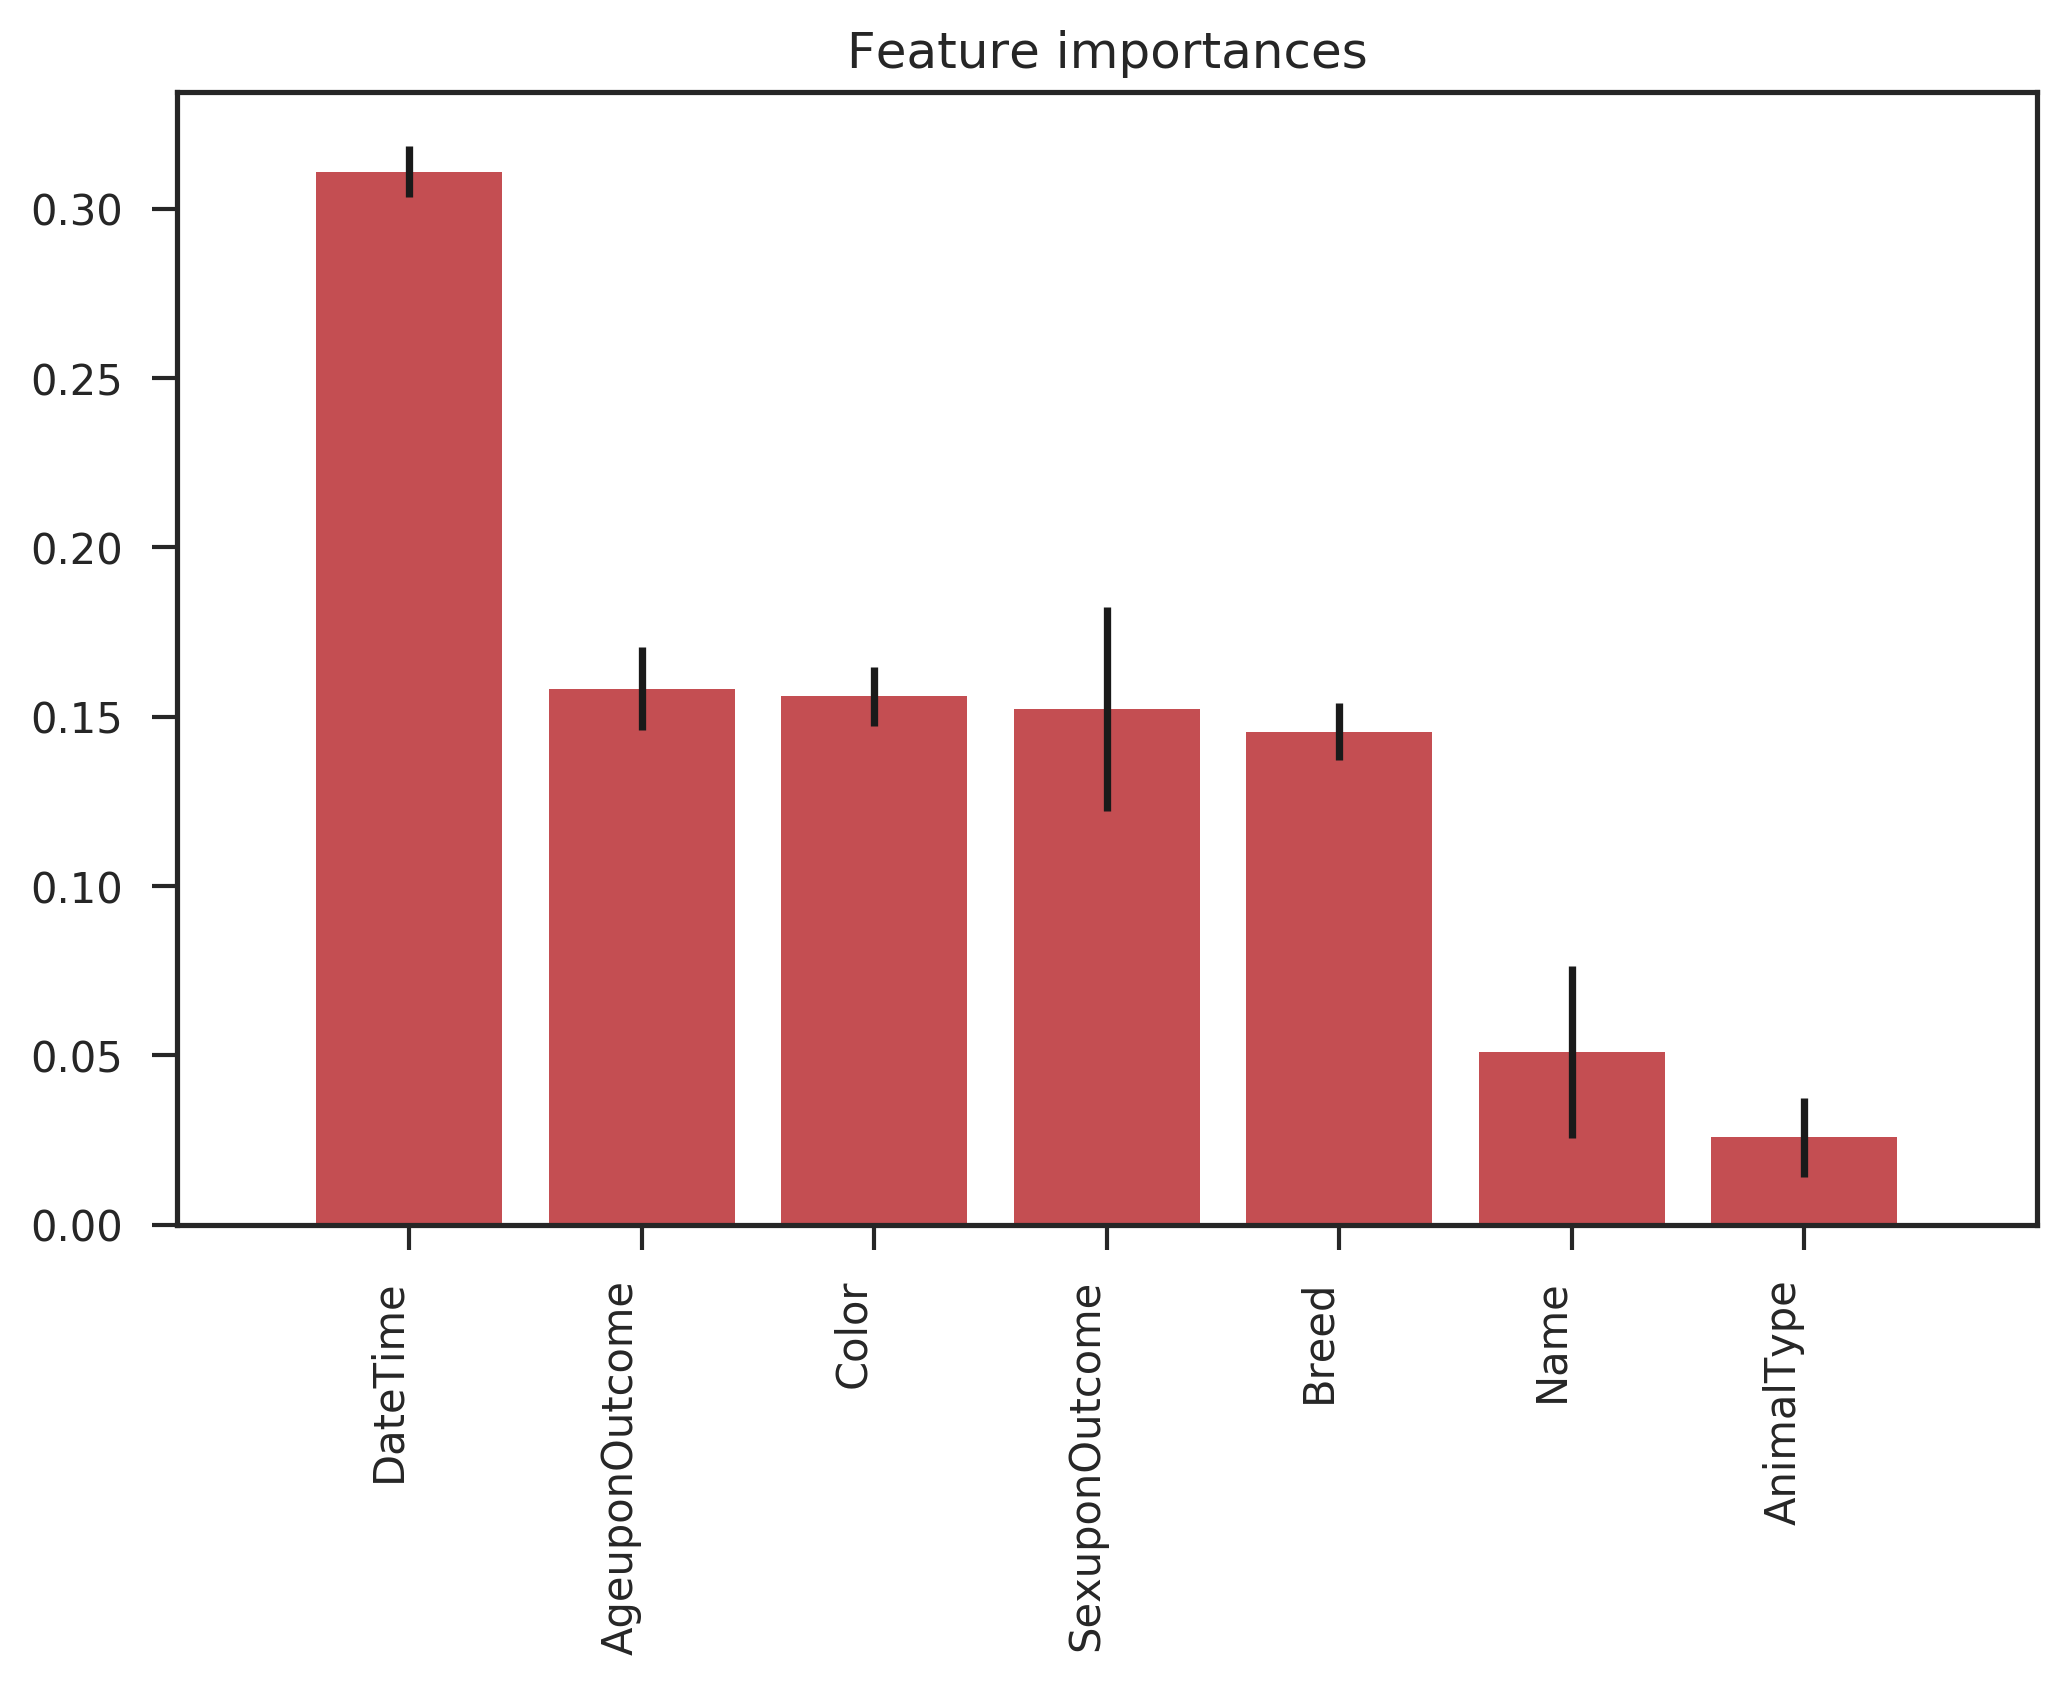

In [70]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
col_names = list()

print("Feature ranking:")
for f in range(df_x.shape[1]):
    print("%d. %s (%f)" % (f + 1, df_x.columns[indices[f]], importances[indices[f]]))
    col_names.append(df_x.columns[indices[f]])

plt.title("Feature importances")
plt.bar(range(df_x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(df_x.shape[1]), col_names, rotation=90, ha="right")
plt.xlim([-1, df_x.shape[1]])
plt.show()

# Random Forest_<font color="red"> 전처리 변수 </font>사용 

In [71]:
columns = ['Name', 'YearMonth', 'Year', 'Month', 'Season', 'Quarter', 'Hour','AnimalType', 'SexuponOutcome', 'DayuponOutcome', 'AboutAge', 'Breed_pre', 'Color_pre', 'BreedMix', 'Group', 'Size']
df_x = df_pre[columns]
df_y = df_pre.iloc[:, [3]]

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(df_x, df_y)

print('log loss: {}'.format(np.mean(-cross_val_score(rf, df_x, df_y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 1.0110668091732329



Feature ranking:
1. DayuponOutcome (0.149828)
2. SexuponOutcome (0.149234)
3. Hour (0.144062)
4. Color_pre (0.093673)
5. YearMonth (0.075719)
6. Breed_pre (0.066450)
7. Month (0.053960)
8. Name (0.049491)
9. Group (0.042644)
10. AboutAge (0.041864)
11. Size (0.035455)
12. Season (0.025055)
13. Year (0.024256)
14. Quarter (0.023704)
15. AnimalType (0.014460)
16. BreedMix (0.010146)


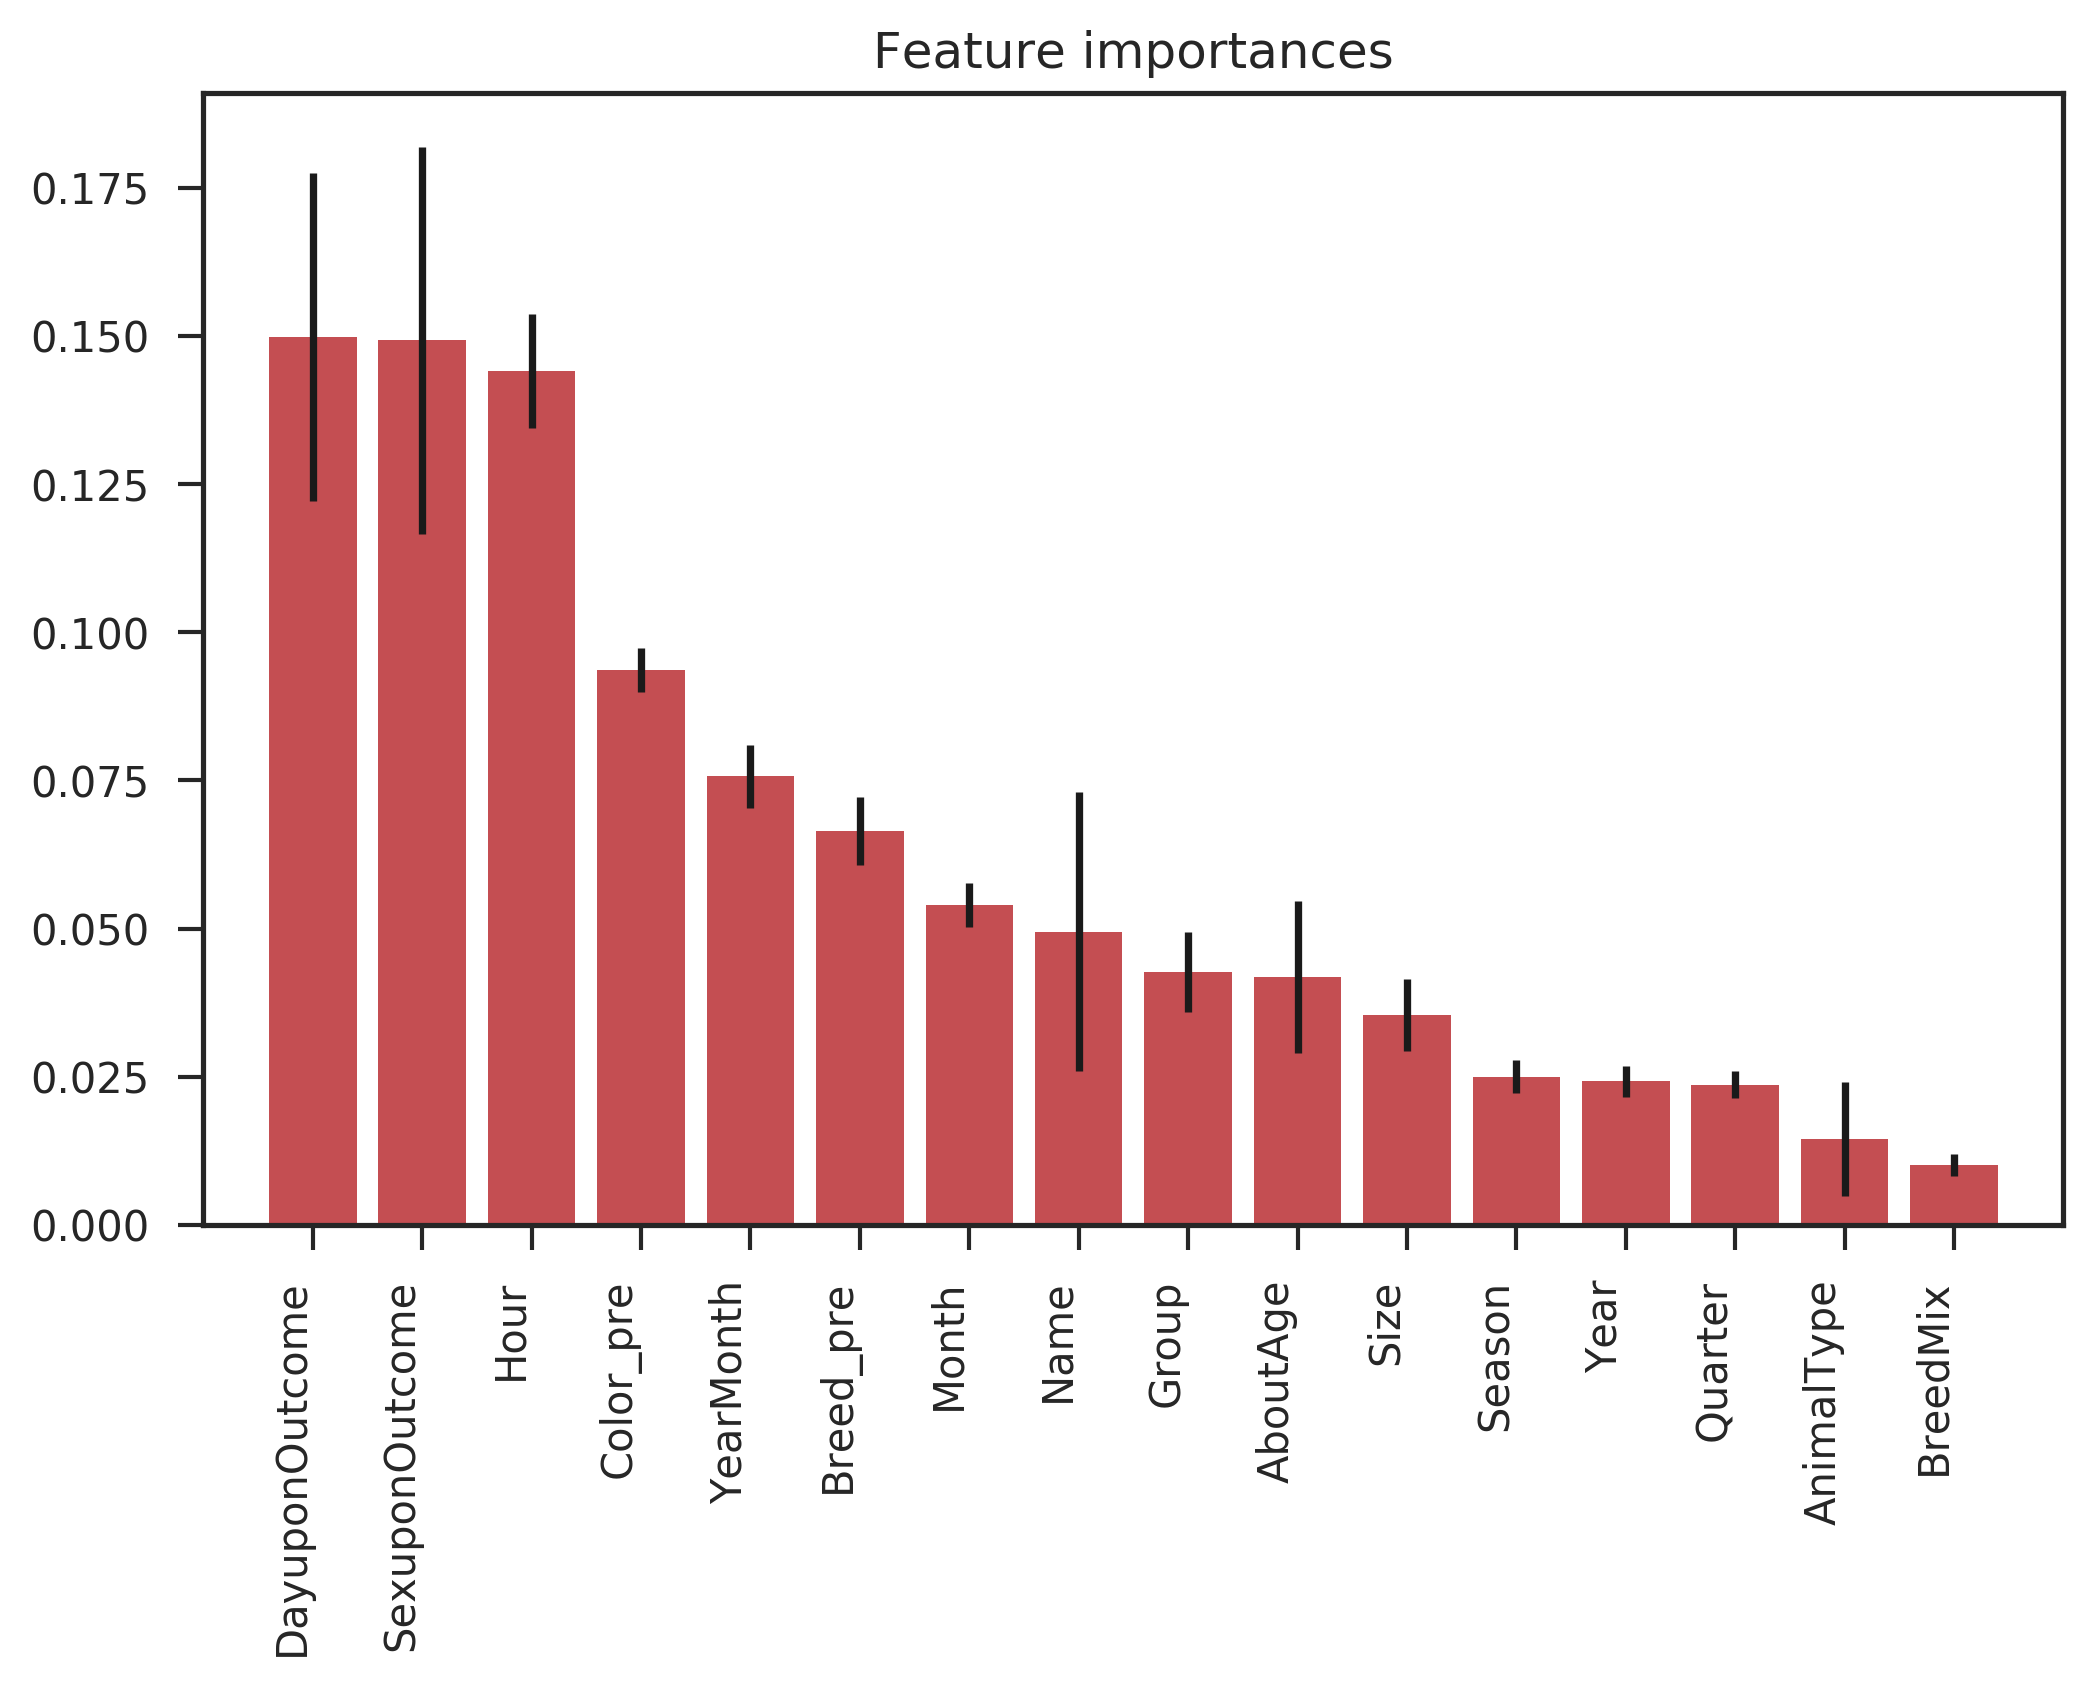

In [72]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
col_names = list()

print("Feature ranking:")
for f in range(df_x.shape[1]):
    print("%d. %s (%f)" % (f + 1, df_x.columns[indices[f]], importances[indices[f]]))
    col_names.append(df_x.columns[indices[f]])

plt.title("Feature importances")
plt.bar(range(df_x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(df_x.shape[1]), col_names, rotation=90, ha="right")
plt.xlim([-1, df_x.shape[1]])
plt.show()

# Random Forest_<font color="red"> mix </font>사용 

In [73]:
columns = ['Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 'DayuponOutcome', 'Breed', 'Color', 'BreedMix','Hour']

df_x = df_pre[columns]
df_y = df_pre.iloc[:, [3]]

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(df_x, df_y)

print('log loss: {}'.format(np.mean(-cross_val_score(rf, df_x, df_y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 1.0140476536536962



Feature ranking:
1. DateTime (0.220028)
2. DayuponOutcome (0.182678)
3. SexuponOutcome (0.141865)
4. Color (0.133302)
5. Hour (0.125043)
6. Breed (0.118696)
7. Name (0.048058)
8. AnimalType (0.021781)
9. BreedMix (0.008550)


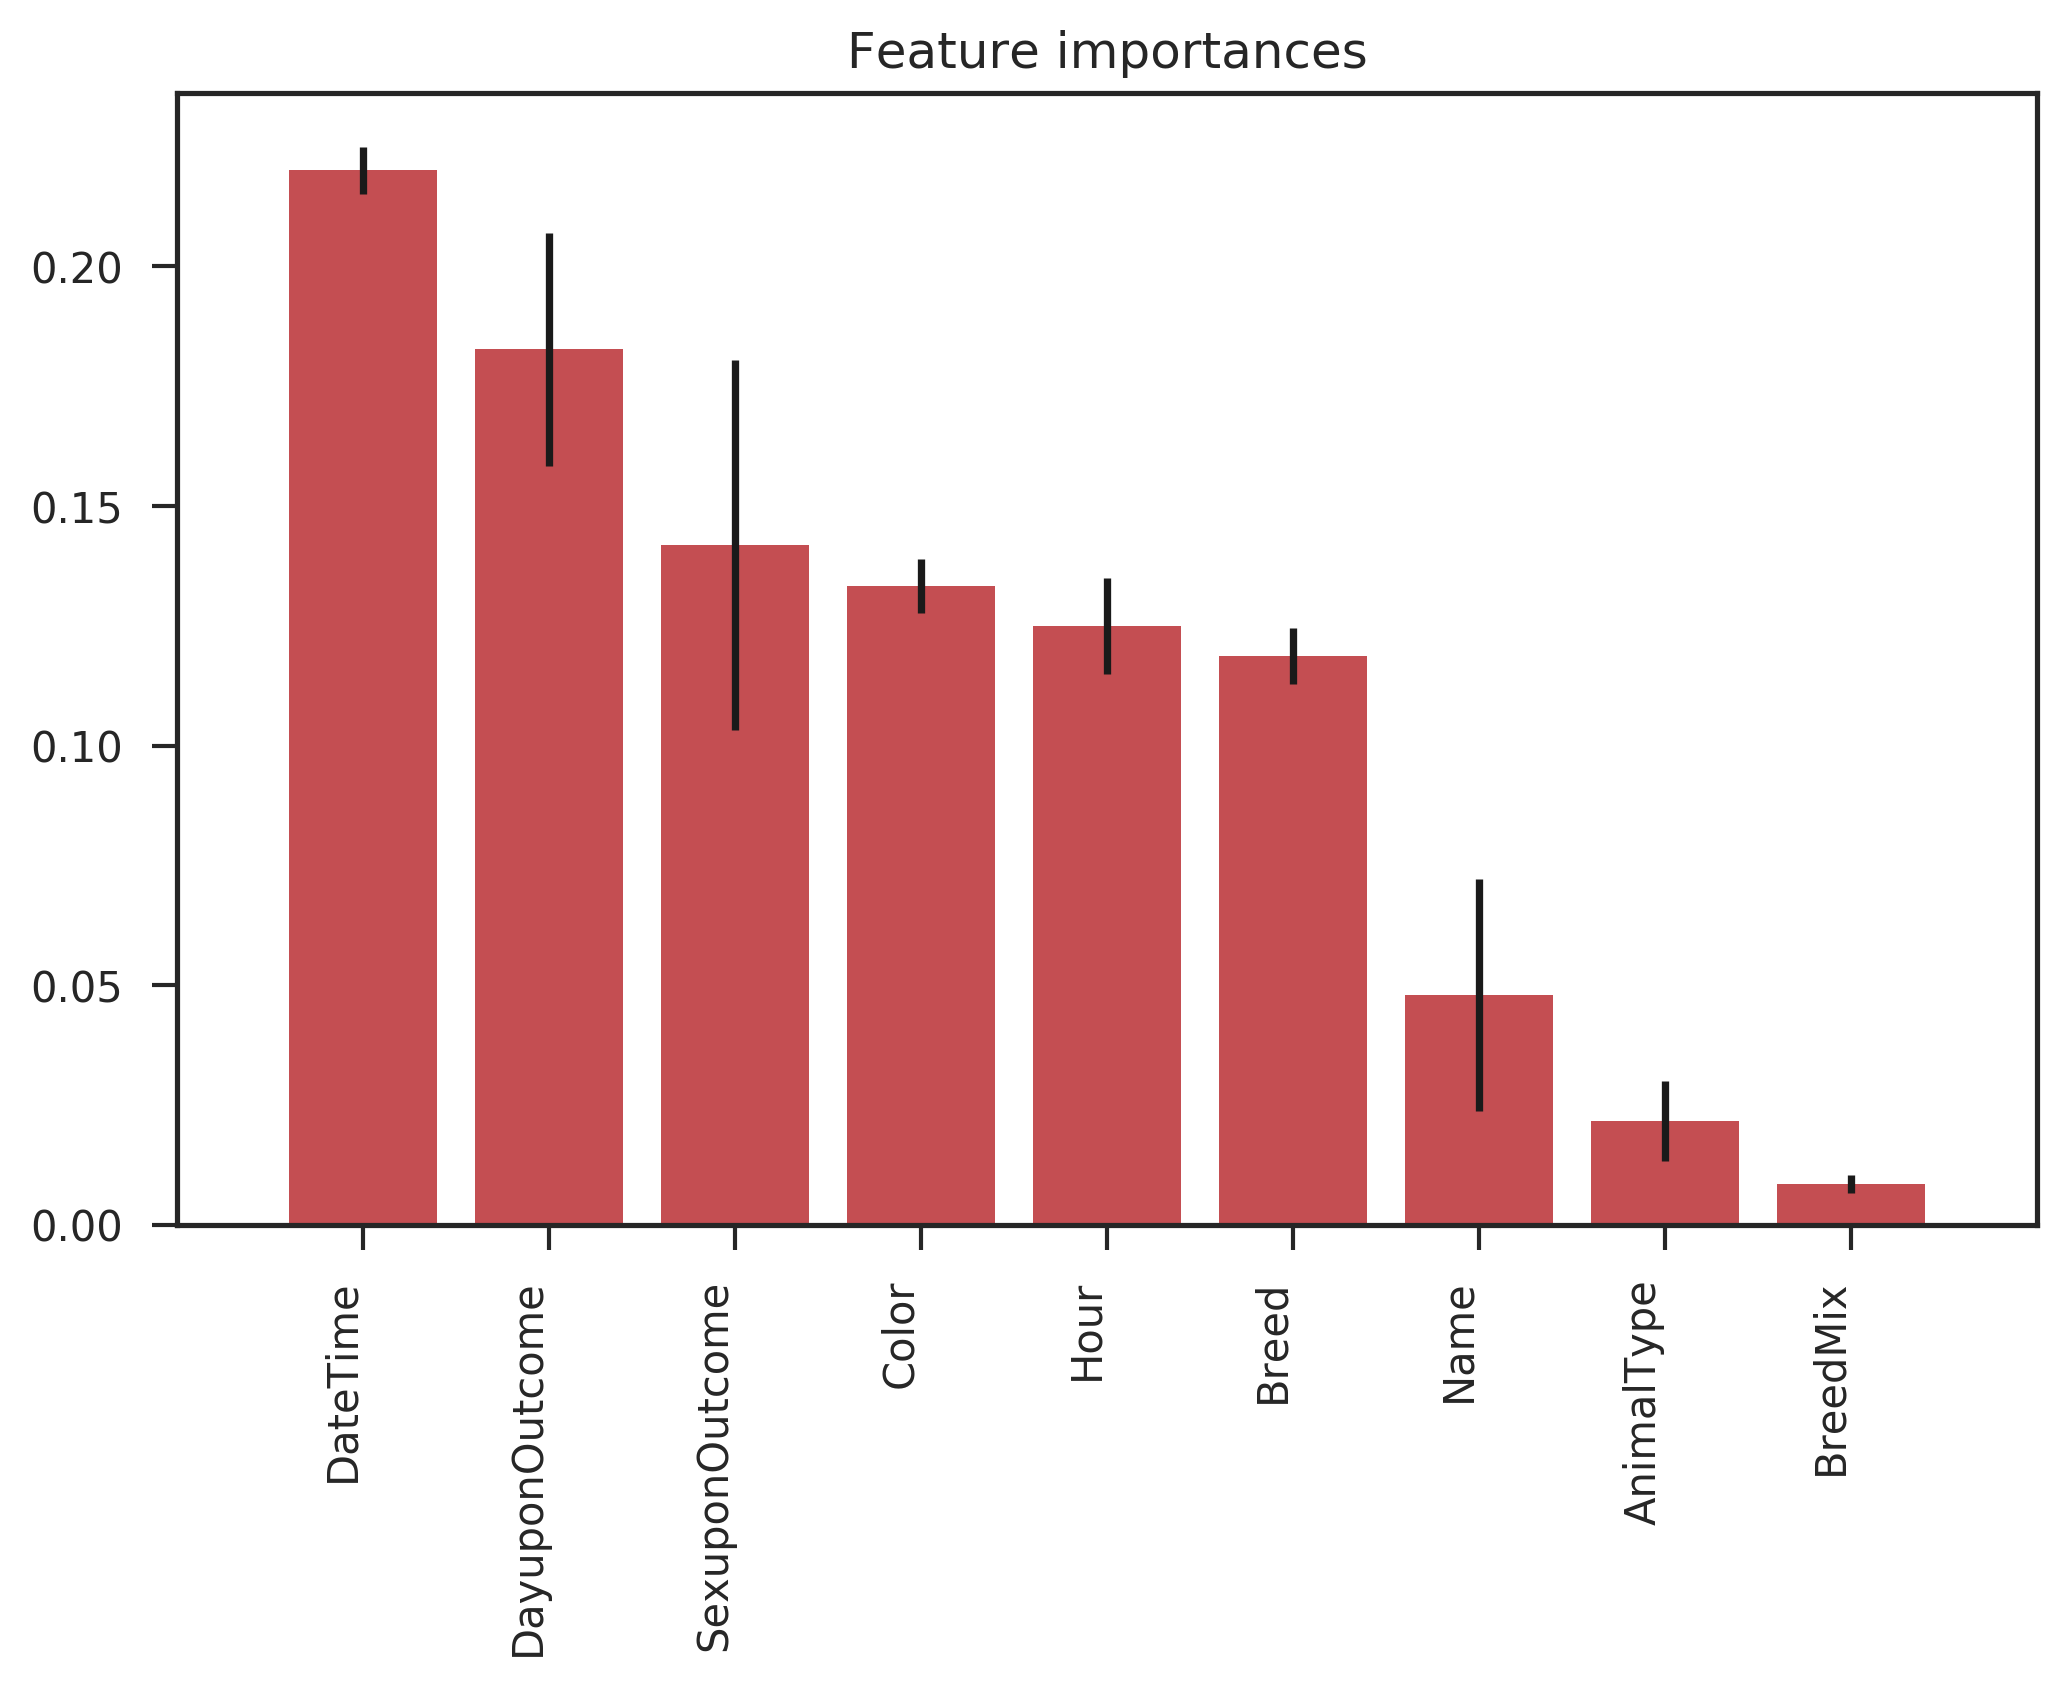

In [74]:
importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
col_names = list()

print("Feature ranking:")
for f in range(df_x.shape[1]):
    print("%d. %s (%f)" % (f + 1, df_x.columns[indices[f]], importances[indices[f]]))
    col_names.append(df_x.columns[indices[f]])

plt.title("Feature importances")
plt.bar(range(df_x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(df_x.shape[1]), col_names, rotation=90, ha="right")
plt.xlim([-1, df_x.shape[1]])
plt.show()

# 모델링
- XGBoost

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

columns = ['Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 'DayuponOutcome', 'Breed', 'Color', 'BreedMix','Hour']

df_x = df_pre[columns]
df_y = df_pre.iloc[:, [3]]

model_xgb = xgboost.XGBClassifier(n_estimators=100)
model_xgb.fit(df_x, df_y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb, df_x, df_y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 0.7947245046378049



# 모델링
- XGBoost <font color = 'red'> 파라미터 조정 후 </font>

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

columns = ['Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 'DayuponOutcome', 'Breed', 'Color', 'BreedMix','Hour']

df_x = df_pre[columns]
df_y = df_pre.iloc[:, [3]]

model_xgb = xgboost.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.05)
model_xgb.fit(df_x, df_y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb, df_x, df_y, scoring="neg_log_loss", cv=cv))))
print()

KeyboardInterrupt: 

# 모델링
- XGBoost <font color = 'red'> 비대칭 조정 후 </font>

In [ ]:
df_imb = df_pre.copy()

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

from imblearn.combine import *
columns = ['Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 'DayuponOutcome', 'Breed', 'Color', 'BreedMix','Hour']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.3, random_state=0, shuffle=True)
X, y = TomekLinks(random_state=0).fit_sample(X_train, y_train)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=220, max_depth=6, learning_rate=0.05)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, X_test, y_test, scoring="neg_log_loss", cv=cv))))
print()

# 제출

<img src="kagglescore.png" />

# 파라미터 튜닝 코드